In [0]:
try:
  %tensorflow_version 2.x
except:
  pass
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
# Load pretrained model from keras.applications. Alternative: TensorflowHub
from tensorflow.keras.applications.mobilenet import MobileNet as PretrainedModel, preprocess_input

In [38]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Convert from grayscale format to RGB format
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)
# Flatten the targets
y_train = y_train.flatten()
y_test = y_test.flatten()
K = len(set(y_train))
print('Number of classes: ' + str(K))
print('Shape of input data: ' + str(x_train.shape))

Number of classes: 10
Shape of input data: (60000, 28, 28, 3)


In [3]:
# Load the model. Note that image size needs to be at least 32x32
TARGET_SIZE = [32, 32]
ptm = PretrainedModel(input_shape=TARGET_SIZE + [3], weights='imagenet', include_top=False)
ptm = Model(ptm.input, Flatten()(ptm.output))
# Number of features produced by the pretrained CNN model
D = ptm.layers[-1].output_shape[1]
print('Output features: ' + str(D))
# Model summary
ptm.summary()

/tensorflow-2.0.0/python3.6/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 1s 0us/step
Output features: 1024
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
________________________________________

In [0]:
# Function to transform images to features vectors with the preloaded model
# This version uses an ImageDataGenerator to process data in batches
def images_to_features(x, model, preprocess_input, batch_size=128):
  # Convert to the image size accepted by the model
  target_size = model.layers[0].input_shape[0][1:3]
  if x.shape[1:3] != target_size:
    x = tf.image.resize(x, size=TARGET_SIZE).numpy()
  # Create a data generator to pipe the images to the model
  gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(x, batch_size=batch_size, shuffle=False)
  # Transform the train images to features vectors via the preloaded model
  N = x.shape[0]
  D = model.layers[-1].output_shape[1]
  X = np.zeros((N, D))
  n_batches = N // batch_size + N % batch_size
  i = 0
  for x_batch in gen:
    # get features
    features = model.predict(x_batch)
    # size of the batch (may not always be batch_size)
    sz = len(x_batch)
    # assign to X_train and Ytrain
    X[i:i + sz] = features
    # increment i
    i += sz
    if (i // sz) % max(1, n_batches // 10) == 0: print(i)
    if i >= N:
      print('breaking now')
      break
  print(i)
  return X


# Function to transform images to features vectors via the preloaded model
# This version is simpler, but not slower.
def images_to_features(x, model, preprocess_input):
  # Convert to the image size accepted by the model
  target_size = model.layers[0].input_shape[0][1:3]
  if x.shape[1:3] != target_size:
    x = tf.image.resize(x, size=TARGET_SIZE).numpy()
  return model.predict(preprocess_input(x))

In [0]:
X_train = images_to_features(x_train, ptm, preprocess_input)
X_test = images_to_features(x_test, ptm, preprocess_input)

In [0]:
# Normalize the features with a scaler.
# Much faster than a BatchNormalization() layer, that requires training.
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

In [0]:
# Train a model to do classification from the feature vectors
i = Input(shape=(D,))
x = i
#x = Dropout(0.2)(x)
x = Dense(D, activation='relu')(x)
#x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

m = Model(i, x)
m.compile(optimizer=Adam(learning_rate=0.001),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

In [125]:
r = m.fit(X_train2, y_train, validation_data=(X_test2, y_test), batch_size=64, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 52us/sample - loss: 1.5752 - accuracy: 0.4669 - val_loss: 1.5775 - val_accuracy: 0.4962
Epoch 2/10
60000/60000 [==============================] - 3s 46us/sample - loss: 1.4559 - accuracy: 0.4945 - val_loss: 1.6077 - val_accuracy: 0.4894
Epoch 3/10
60000/60000 [==============================] - 3s 46us/sample - loss: 1.4319 - accuracy: 0.5045 - val_loss: 1.5829 - val_accuracy: 0.4961
Epoch 4/10
60000/60000 [==============================] - 3s 46us/sample - loss: 1.4161 - accuracy: 0.5059 - val_loss: 1.6368 - val_accuracy: 0.5068
Epoch 5/10
60000/60000 [==============================] - 3s 46us/sample - loss: 1.4112 - accuracy: 0.5107 - val_loss: 1.6726 - val_accuracy: 0.5042
Epoch 6/10
60000/60000 [==============================] - 3s 46us/sample - loss: 1.3900 - accuracy: 0.5159 - val_loss: 1.6329 - val_accuracy: 0.4990
Epoch 7/10
60000/60000 [==============================] 

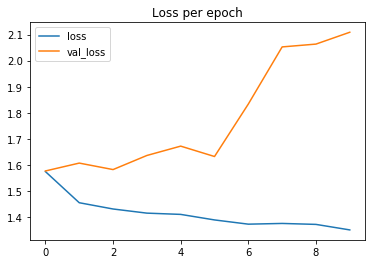

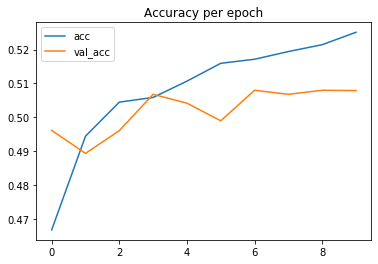

In [126]:
plt.title('Loss per epoch')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.title('Accuracy per epoch')
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [0]:
# Combined model: preprocess_input + ptm + scaler + m
def cm_predict(x):
  return m.predict(scaler.transform(images_to_features(x, ptm, preprocess_input)))

p_test = cm_predict(x_test).argmax(axis=1)

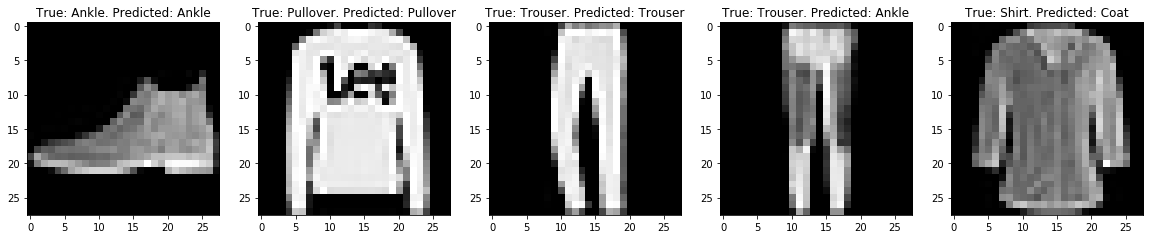

In [128]:
labels = '''
  T-shirt/top
  Trouser
  Pullover
  Dress
  Coat
  Sandal
  Shirt
  Sneaker
  Bag
	Ankle boot'''.split()

plt.figure(figsize=(20, 10))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(x_test[i], cmap='gray')
  plt.title("True: %s. Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));
plt.show()

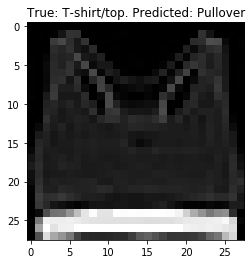

Continue? (Y/n): Y


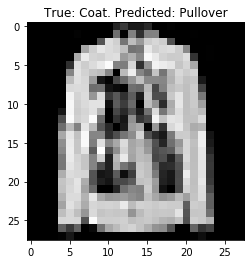

Continue? (Y/n): n


In [129]:
# Show some misclassified examples
p_test = m.predict(X_test2).argmax(axis=1)  # faster to start from the scaled feature vectors
misclassified_idx = np.where(p_test != y_test)[0]
while True:
  i = np.random.choice(misclassified_idx)
  # plt.figure(dpi=50)
  plt.imshow(x_test[i], cmap='gray')
  plt.title("True: %s. Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));
  plt.show()
  if input(prompt='Continue? (Y/n): ') == 'n': break